# Multi-phase smoothed boundary method (MP-SBM)
**Author**: Simon Daubner

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sbm_utils as sbm

## Visualization of the smooth boundary method

1. Create sharp field of multiple phases (label 0: electrolyte, label 1-3: grains)
2. Smoothen fields by applying multi-phase field method
3. Plot comparison of (sharp) pixelated field which could be input from imaging and segmentation together with smooth fields and |grad(phi)|

In [2]:
Nx, Ny = [26, 26]
px = 1 # pixel resolution

grid = sbm.VoxelFields(Nx, Ny, (px,px))
grid.add_field("phiindex")

grid.add_voxel_sphere("phiindex", 9, 9, 4, label=1)
grid.add_voxel_sphere("phiindex", 13, 16, 5, label=2)
grid.add_voxel_sphere("phiindex", 17, 9, 4, label=3)

### Solve phase-field evolution

In [3]:
sim = sbm.MultiPhaseSolver(grid, "phiindex", eps=2, stabilize=0.05)
sim.solve_without_curvature(steps=20, frames=10, dt=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000000000002].


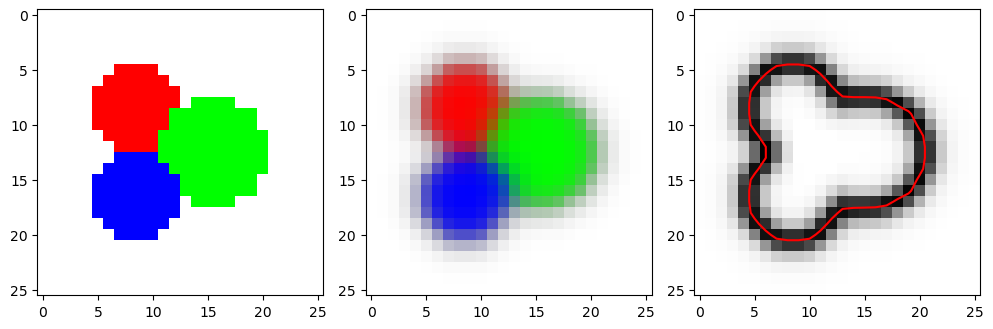

In [4]:
def map_to_rgb(phia, phib, phic):
    """Plot three overlapping fields as an RGB image."""
    rgb_image = np.zeros((*phia.shape, 4))  # Initialize an empty RGB image
    rgb_image[..., 0] = phia   # Red channel
    rgb_image[..., 1] = phib   # Green channel
    rgb_image[..., 2] = phic   # Blue channel
    rgb_image[..., 3] = phia+phib+phic # Opacity
    return rgb_image

initial = map_to_rgb(grid.fields["phiindex"]==1, grid.fields["phiindex"]==2, grid.fields["phiindex"]==3)
after = map_to_rgb(grid.fields["phi1"], grid.fields["phi2"], grid.fields["phi3"])

fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
ax0.imshow(initial)
ax1.imshow(after)
ax2.imshow(grid.fields["phi0"]*(1-grid.fields["phi0"]), cmap='Grays')
ax2.contour(grid.fields["phi0"], levels=[0.5], colors=['red'])
plt.tight_layout()
plt.show()


## Fitting of reaction kinetics

Data for NMC811 is taken from Figure S22 in the Supporting Information of [Zhang et. al. 2024](https://chemrxiv.org/engage/chemrxiv/article-details/6653c53621291e5d1d57ad8b). The data is then fitted using the case of ion-coupled electron transfer (ICET) from the general CIET theory by [Bazant](https://pubs.rsc.org/en/content/articlelanding/2023/fd/d3fd00108c). This corresponds to Equation 6-9 in [Zhang et. al. 2024](https://chemrxiv.org/engage/chemrxiv/article-details/6653c53621291e5d1d57ad8b).

alpha: 0.5052665505325806, k0: 0.11824987850601364


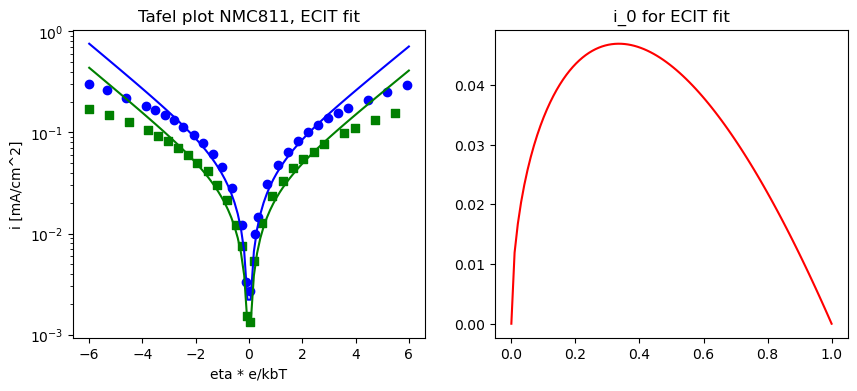

In [5]:
from scipy.optimize import curve_fit

# Load experimental data
data = np.loadtxt("data/NMC811_06.txt", skiprows=1)
eta_06 = data[:, 0]
current_06 = data[:, 1]
data = np.loadtxt("data/NMC811_08.txt", skiprows=1)
eta_08 = data[:, 0]
current_08 = data[:, 1]

def ICET_current(eta, alpha, k0, c0):
    return np.abs(k0* c0**alpha * (1-c0) * (np.exp(-alpha*eta) - np.exp((1-alpha)*eta)))

def BV_current(eta, alpha, k0, c0):
    return np.abs(k0* c0**alpha * (1-c0)**alpha * (np.exp(-alpha*eta) - np.exp((1-alpha)*eta)))

def fit_ICET(eta, alpha, k0):
    return ICET_current(eta, alpha, k0, c0_stack)

# Combine the datasets
eta_stack = np.concatenate([eta_06, eta_08])
current_stack = np.concatenate([current_06, current_08])

# Plot fitted curve alongside the data
limit = 3
subset = (eta_stack >= -limit) & (eta_stack <= limit)
c0_stack = np.concatenate([np.full_like(eta_06, 0.6), np.full_like(eta_08, 0.8)])[subset]
initial_guess = (0.5, 1)
bounds= ([0.1, 0.001], [0.9, 100])
popt, pcov = curve_fit(fit_ICET, eta_stack[subset], current_stack[subset], p0=initial_guess, bounds=bounds)
alpha_fit, k0_fit = popt
print(f'alpha: {alpha_fit}, k0: {k0_fit}')

eta_range = np.linspace(-6, 6, 100)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax0.plot(eta_range, ICET_current(eta_range, alpha_fit, k0_fit, 0.6), color='blue', linestyle='solid', label='Fit (c0=0.6)')
# ax0.plot(eta_range, BV_current(eta_range, alpha_fit, k0_fit, 0.6), color='blue', linestyle='dashed', label='Fit (c0=0.6)')
ax0.scatter(eta_06, current_06, color='blue', label='c0=0.6', marker='o')

ax0.plot(eta_range, ICET_current(eta_range, alpha_fit, k0_fit, 0.8), color='green', linestyle='solid', label='Fit (c0=0.8)')
# ax0.plot(eta_range, BV_current(eta_range, alpha_fit, k0_fit, 0.8), color='green', linestyle='dashed', label='Fit (c0=0.8)')
ax0.scatter(eta_08, current_08, color='green', label='c0=0.8', marker='s')

ax0.set_xlabel('eta * e/kbT')
ax0.set_ylabel('i [mA/cm^2]')
ax0.set_yscale('log')
ax0.set_title('Tafel plot NMC811, ECIT fit')

ax1.plot(np.linspace(0, 1, 100), ICET_current(1, alpha_fit, k0_fit, np.linspace(0, 1, 100)), color='red', linestyle='solid', label='Fit (c0=0.8)')
# ax1.plot(np.linspace(0, 1, 100), BV_current(1, alpha_fit, k0_fit, np.linspace(0, 1, 100)), color='purple', linestyle='dashed', label='Fit (c0=0.8)')
ax1.set_title('i_0 for ECIT fit')
plt.show()

## Fitting chemical energies

Data for LiNiO2 is taken from [de Biasi et. al. 2019](https://onlinelibrary.wiley.com/doi/10.1002/cssc.201900032). First, we load experimental data and define the concentration ranges of single phase regions according the the original work of [de Biasi et. al. 2019](https://onlinelibrary.wiley.com/doi/10.1002/cssc.201900032). The overall concentration range is defined in the limits of [0.01, 0.99] to avoid numerical issues with logarithmic expressions close to 0 and 1.

In [6]:
# Load experimental data
data = np.loadtxt("data/DeBiasi2019_LNO_third_charge.txt", skiprows=1)
C10charge_x = data[:, 2]  # X column
C10charge_y = data[:, 1]  # Voltage column
data = np.loadtxt("data/DeBiasi2019_LNO_third_discharge.txt", skiprows=1)
C10discharge_x = data[:, 2]  # X column
C10discharge_y = data[:, 1]  # Voltage column

# Define individual phases and concentration range of their single phase region
phases = ["H3", "H2", "M", "H1"]
limits = [[0.02, 0.1], [0.25, 0.31], [0.38, 0.74], [0.8, 0.94]]
domain_limit=[0.01, 0.99]

As discussed in [Daubner et. al. 2024](https://www.nature.com/articles/s41524-024-01258-x), quadratic and logarithmic fitting functions can be used for phase-specific chemical energies in the context of the multi-phase field method. All functions, derivatives etc. are defined in the `sbm_utils.py` file. in this case, we choose to fit all phase energies with logarithmic contributions and adjust the manual bounds such that individual voltage curves do not intersect.

/mnt/c/Users/sdaubner/workspace/multi-phase-sbm/sbm_utils.py:251: OptimizeWarning: Covariance of the parameters could not be estimated
  param_fit[phases[i]], _ = curve_fit(fit_func, voltage_data[0][subset], -voltage_data[1][subset], p0=initial_guess, bounds=(lower_bounds, upper_bounds))


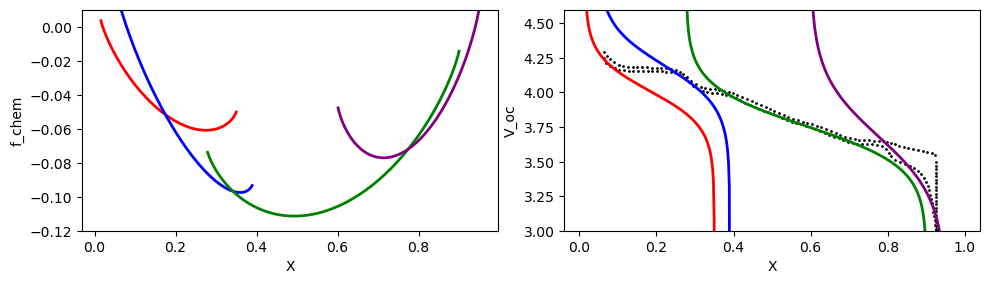

In [7]:
# Use log type fitting for first and last phase
fit_type = ["log", "log", "log", "log"] # log or quad
manual_bounds = [ [[0.01, 0.26], [0.05, 0.39], [0.25, 0.81], [0.6, 0.95]] , [[0.02, 0.35], [0.09, 0.4], [0.30, 0.9], [0.73, 0.99]] ]
V_ref, param_fit, B_fit, phase_limits = sbm.fit_experimental_voltage(phases, fit_type, limits, domain_limit, np.array([C10discharge_x,C10discharge_y]), \
                                                       manual_bounds=manual_bounds)

# Plot fitted curve alongside the data
x_fit = np.linspace(domain_limit[0], domain_limit[1], 500)

colors = ["red", "blue", "green", "purple"]
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
for i in range(len(phases)):
    f_func  = getattr(sbm, f"free_energy_{fit_type[i]}")
    if fit_type[i] == "log":
        subset = (x_fit >= param_fit[phases[i]][2]) & (x_fit <= param_fit[phases[i]][3])
    elif fit_type[i] == "quad":
        subset = (x_fit >= 0)
    f_fit = f_func(x_fit[subset], *param_fit[phases[i]], B_fit[phases[i]])
    ax0.plot(x_fit[subset], f_fit, label=phases[i], color=colors[i], linewidth=2)
ax0.set_xlabel("X")
ax0.set_ylabel("f_chem")
ax0.set_ylim(-0.12, 0.01)

ax1.scatter(C10charge_x, C10charge_y, label="Data", s=1, color="black")
ax1.scatter(C10discharge_x, C10discharge_y, label="Data", s=1, color="black")
for i in range(len(phases)):
    mu_func = getattr(sbm, f"chemical_potential_{fit_type[i]}")
    Voc_fit = V_ref - mu_func(x_fit, *param_fit[phases[i]])
    ax1.plot(x_fit, Voc_fit, label=phases[i], color=colors[i], linewidth=2)
ax1.set_xlabel("X")
ax1.set_ylabel("V_oc")
ax1.set_ylim(3, 4.6)
plt.tight_layout()
plt.show()


Check phase-field driving forces and stability of two-phase regions following the stability analysis in [Daubner et. al. 2021](https://link.aps.org/doi/10.1103/PhysRevMaterials.5.035406) and [Daubner 2023](https://publikationen.bibliothek.kit.edu/1000164858).

/mnt/c/Users/sdaubner/workspace/multi-phase-sbm/sbm_utils.py:209: RuntimeWarning: overflow encountered in exp
  return (c0 + c1 * np.exp((mu*factor-A)/K)) / (1+np.exp((mu*factor-A)/K))
/mnt/c/Users/sdaubner/workspace/multi-phase-sbm/sbm_utils.py:209: RuntimeWarning: invalid value encountered in divide
  return (c0 + c1 * np.exp((mu*factor-A)/K)) / (1+np.exp((mu*factor-A)/K))
/mnt/c/Users/sdaubner/workspace/multi-phase-sbm/sbm_utils.py:213: RuntimeWarning: overflow encountered in exp
  return (c1-c0) / K * np.exp((mu*factor-A)/K) / (1+np.exp((mu*factor-A)/K)) / (1+np.exp((mu*factor-A)/K))
/mnt/c/Users/sdaubner/workspace/multi-phase-sbm/sbm_utils.py:213: RuntimeWarning: invalid value encountered in divide
  return (c1-c0) / K * np.exp((mu*factor-A)/K) / (1+np.exp((mu*factor-A)/K)) / (1+np.exp((mu*factor-A)/K))
/tmp/ipykernel_134375/2043829428.py:31: RuntimeWarning: divide by zero encountered in divide
  mu += delta_c / dc_dmu
/tmp/ipykernel_134375/2043829428.py:31: RuntimeWarning: overfl

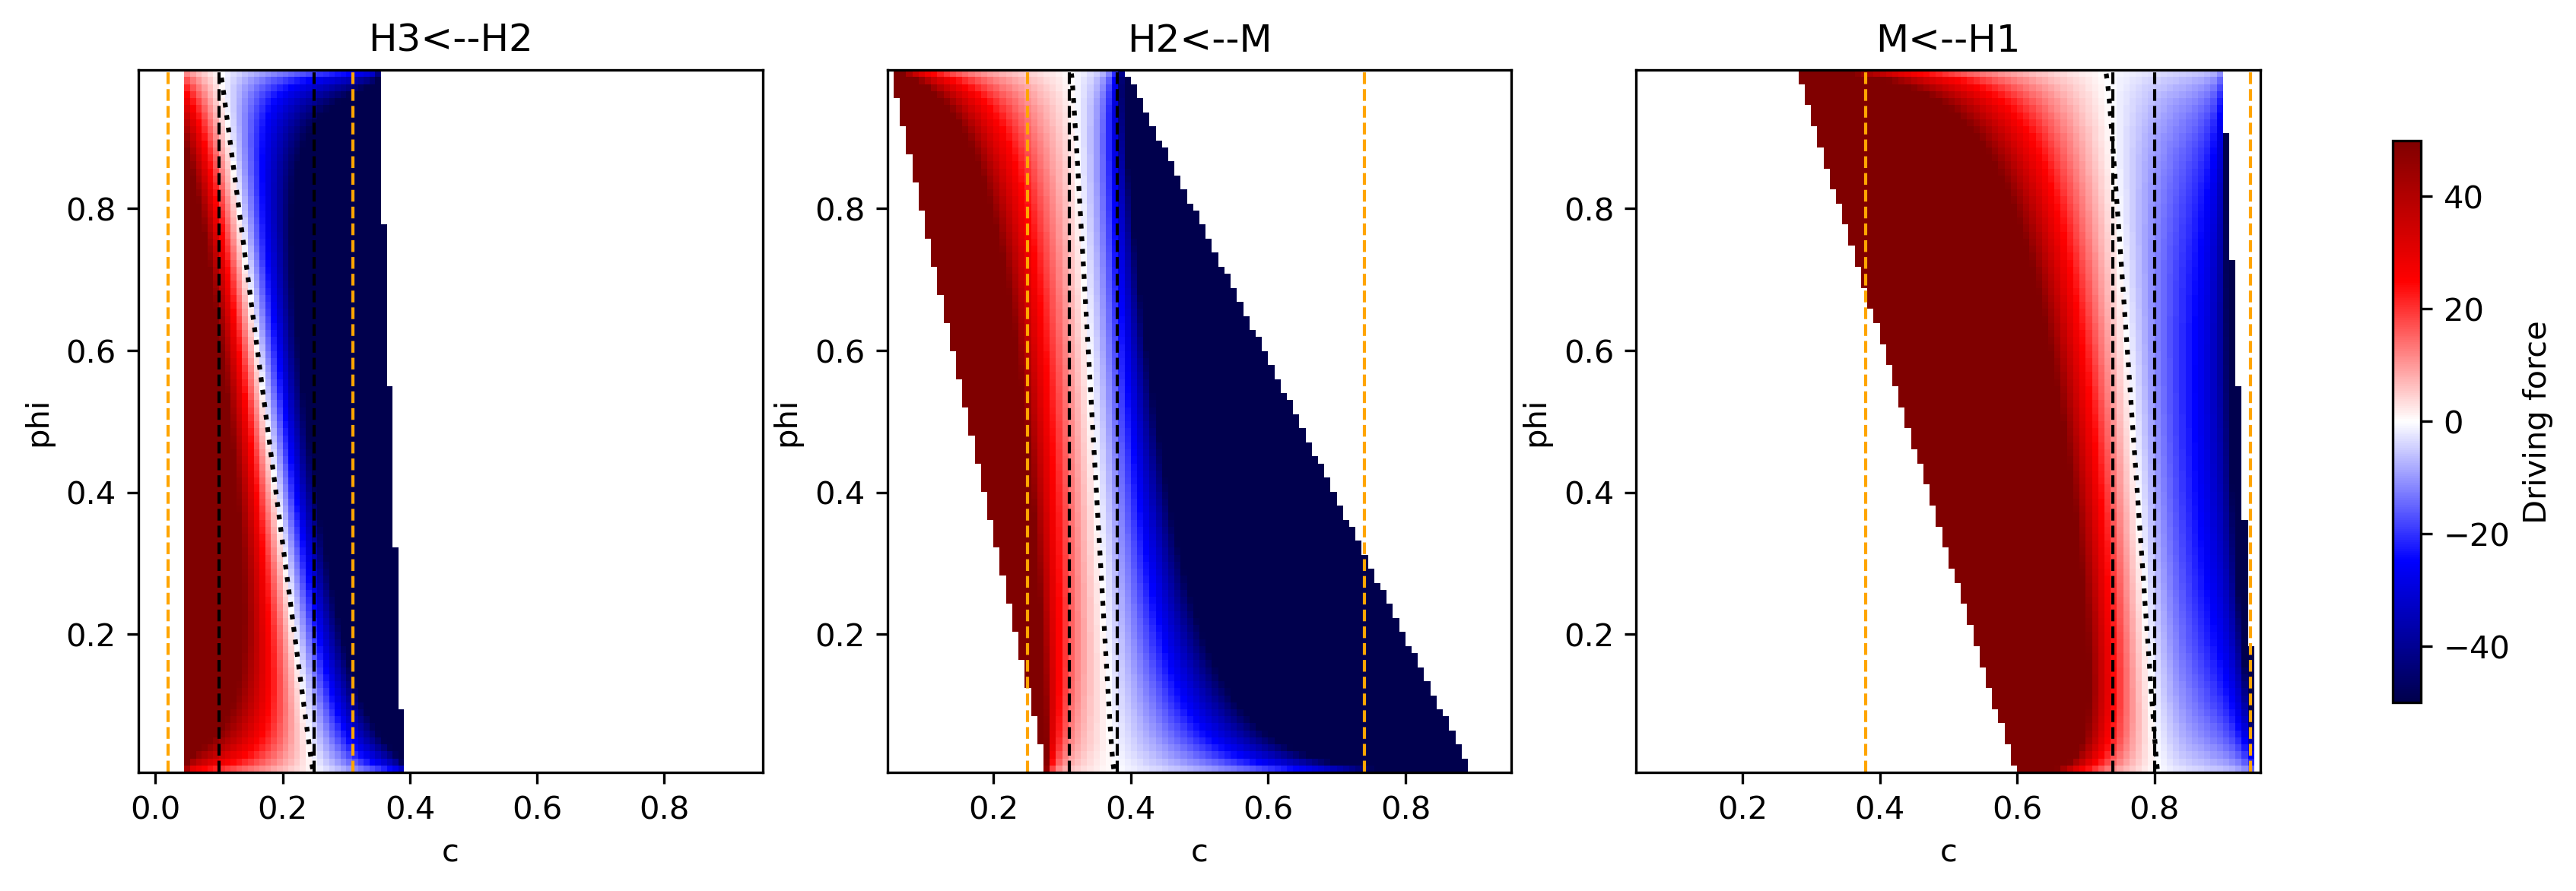

In [8]:
R = 8.314462
T = 300
cref  = 41211
eps   = 3e-7
gamma = 2.0/(R*T*cref)

def convert_c2mu_twophase(c, phia, idx=[0,1], steps=15, factor=1):
    mu_func = getattr(sbm, f"chemical_potential_{fit_type[idx[0]]}")
    mu_a = mu_func(c, *param_fit[phases[idx[0]]], factor=factor)
    mu_func = getattr(sbm, f"chemical_potential_{fit_type[idx[0]]}")
    mu_b = mu_func(c, *param_fit[phases[idx[0]]], factor=factor)
    mu = mu_a*phia + mu_b*(1-phia)
    mu = -15 + c*30
    iter = 0
    while iter<steps:
        # update mu through dc/dmu*delta_mu = c - c(phi, mu_iter, T)
        dc_dmu = 0.0
        c_iter = 0.0
        ci_func = getattr(sbm, f"ci_of_mu_{fit_type[idx[0]]}")
        c_iter += ci_func(mu, *param_fit[phases[idx[0]]], factor=factor)*phia
        ci_func = getattr(sbm, f"ci_of_mu_{fit_type[idx[1]]}")
        c_iter += ci_func(mu, *param_fit[phases[idx[1]]], factor=factor)*(1-phia)

        dci_func = getattr(sbm, f"dci_dmu_{fit_type[idx[0]]}")
        dc_dmu += dci_func(mu, *param_fit[phases[idx[0]]], factor=factor)*phia
        dci_func = getattr(sbm, f"dci_dmu_{fit_type[idx[1]]}")
        dc_dmu += dci_func(mu, *param_fit[phases[idx[1]]], factor=factor)*(1-phia)

        # update mu
        delta_c = c - c_iter
        mu += delta_c / dc_dmu
        iter += 1
    return mu

phia = np.linspace(0.01, 0.99, 100)
c = np.linspace(0.05, 0.95, 100)
c, phia = np.meshgrid(c, phia)

drive = {}
factor=1 #sbm.e_over_kbT
for k in range(1,len(phases)):
    steps = 15
    mu = convert_c2mu_twophase(c, phia, idx=[k-1,k], steps=steps, factor=factor)
    mask = (np.abs(convert_c2mu_twophase(c, phia, idx=[k-1,k], steps=steps+1, factor=factor)-mu)>1e-2)
    mu[mask] = np.inf
    ci_a = getattr(sbm, f"ci_of_mu_{fit_type[k-1]}")
    ci_a = ci_a(mu, *param_fit[phases[k-1]], factor=factor)
    ci_b = getattr(sbm, f"ci_of_mu_{fit_type[k]}")
    ci_b = ci_b(mu, *param_fit[phases[k]], factor=factor)

    f_a  = getattr(sbm, f"free_energy_{fit_type[k-1]}")
    f_b  = getattr(sbm, f"free_energy_{fit_type[k]}")
    name = phases[k-1] + "<--" + phases[k]
    drive[name] = 4*np.sqrt(phia*(1-phia))*sbm.e_over_kbT \
                  * (mu*(ci_a - ci_b) \
                     - f_a(ci_a, *param_fit[phases[k-1]], B_fit[phases[k-1]], factor=factor) \
                     + f_b(ci_b, *param_fit[phases[k]], B_fit[phases[k]], factor=factor)) \
                  + (8 * gamma / (eps * np.pi)*(1-2*phia))

fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), dpi=300)
axes = [ax0, ax1, ax2]
abs = 50
for i, (name, field) in enumerate(drive.items()):
    pcm  = axes[i].pcolormesh(c, phia, field, cmap='seismic', shading='auto', vmin=-abs, vmax=abs)
    axes[i].contour(c, phia, field, levels=[0], colors='black', linestyles='dotted')
    axes[i].axvline(x=limits[i][0], color='orange', linestyle='dashed', linewidth=1)
    axes[i].axvline(x=limits[i][1], color='black', linestyle='dashed', linewidth=1)
    axes[i].axvline(x=limits[i+1][0], color='black', linestyle='dashed', linewidth=1)
    axes[i].axvline(x=limits[i+1][1], color='orange', linestyle='dashed', linewidth=1)
    axes[i].set_xlabel("c")
    axes[i].set_ylabel("phi")
    axes[i].set_title(name)

fig.colorbar(pcm, ax=axes, location='right', orientation='vertical', label='Driving force', shrink=0.8)
plt.show()

Print parameters to include into PACE simulation framework

In [9]:
print(f"# Reference voltage V_ref: {V_ref:.4f}\n")

for i in range(len(phases)):
    if fit_type[i] == "log":
        print(f"# Params of {phases[i]} for {fit_type[i]} fit:")
        print(f"DefineConst=A_{phases[i]}, {param_fit[phases[i]][0]:.4f}")
        print(f"DefineConst=K_{phases[i]}, {param_fit[phases[i]][1]:.4f}")
        print(f"DefineConst=c0_{phases[i]}, {param_fit[phases[i]][2]:.4f}")
        print(f"DefineConst=c1_{phases[i]}, {param_fit[phases[i]][3]:.4f}")
        print(f"DefineConst=B_{phases[i]}, {B_fit[phases[i]]:.4f}")
    elif fit_type[i] == "quad":
        print(f"# Params of {phases[i]} for {fit_type[i]} fit:")
        print(f"DefineConst=A_{phases[i]}, {param_fit[phases[i]][0]:.4f}")
        print(f"DefineConst=B_{phases[i]}, {param_fit[phases[i]][1]:.4f}")
        print(f"DefineConst=C_{phases[i]}, {B_fit[phases[i]]:.4f}")

# Reference voltage V_ref: 3.8500

# Params of H3 for log fit:
DefineConst=A_H3, -6.2244
DefineConst=K_H3, 5.0000
DefineConst=c0_H3, 0.0155
DefineConst=c1_H3, 0.3500
DefineConst=B_H3, 2.0745
# Params of H2 for log fit:
DefineConst=A_H2, -13.3718
DefineConst=K_H2, 5.7752
DefineConst=c0_H2, 0.0500
DefineConst=c1_H2, 0.3900
DefineConst=B_H2, 3.7450
# Params of M for log fit:
DefineConst=A_M, 3.6189
DefineConst=K_M, 5.7067
DefineConst=c0_M, 0.2773
DefineConst=c1_M, 0.9000
DefineConst=B_M, -2.1174
# Params of H1 for log fit:
DefineConst=A_H1, 6.4314
DefineConst=K_H1, 8.7263
DefineConst=c0_H1, 0.6000
DefineConst=c1_H1, 0.9500
DefineConst=B_H1, -2.4429


Check invertible relation c(mu) and the thermodynamic factor

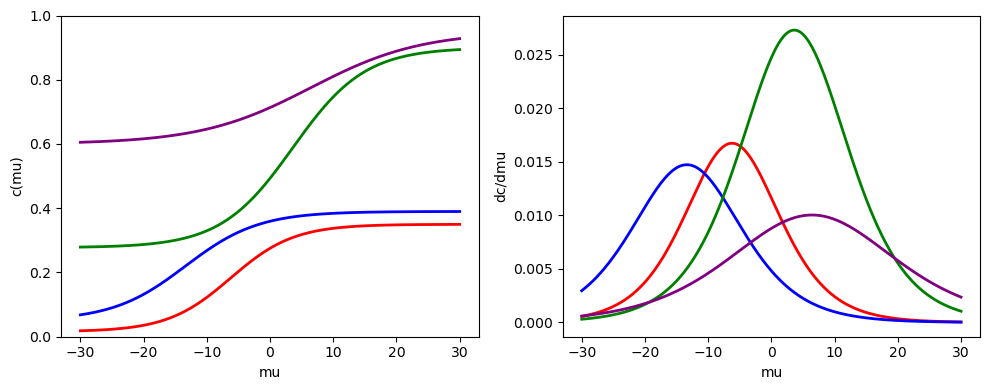

In [10]:
factor = 1
mu_range = np.linspace(-30/factor, 30/factor, 500)

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i in range(len(phases)):
    ci_func = getattr(sbm, f"ci_of_mu_{fit_type[i]}")
    ax0.plot(mu_range, ci_func(mu_range, *param_fit[phases[i]], factor=factor), label=phases[i], color=colors[i], linewidth=2)
ax0.set_xlabel("mu")
ax0.set_ylabel("c(mu)")
ax0.set_ylim(0, 1)

for i in range(len(phases)):
    dci_func = getattr(sbm, f"dci_dmu_{fit_type[i]}")
    ax1.plot(mu_range, dci_func(mu_range, *param_fit[phases[i]], factor=factor), label=phases[i], color=colors[i], linewidth=2)
ax1.set_xlabel("mu")
ax1.set_ylabel("dc/dmu")
# ax1.set_ylim(0, 0.1)
plt.tight_layout()
plt.show()

During the simulation of phase transitions within the multiphase-field framework, a noise term has to be added. Otherwise a phase variable phi might stay equal to zero everywhere in the domain although the driving force might be positive for any small value larger than zero. Adding noise to the simulation to enable nucleation must conserve the mass balance, i.e. the concentration value in each cell should not be altered by the noise added to the phase-field variables. Therefore, the chemical potential has to be computed for the new phis such that c_old = c_new. Algorithmically, this can be solved with a local fix point scheme (Newton iterations for every grid point). Stability of this algortihm is tested here:

Not converged, -2.275957200481571e-15 lost


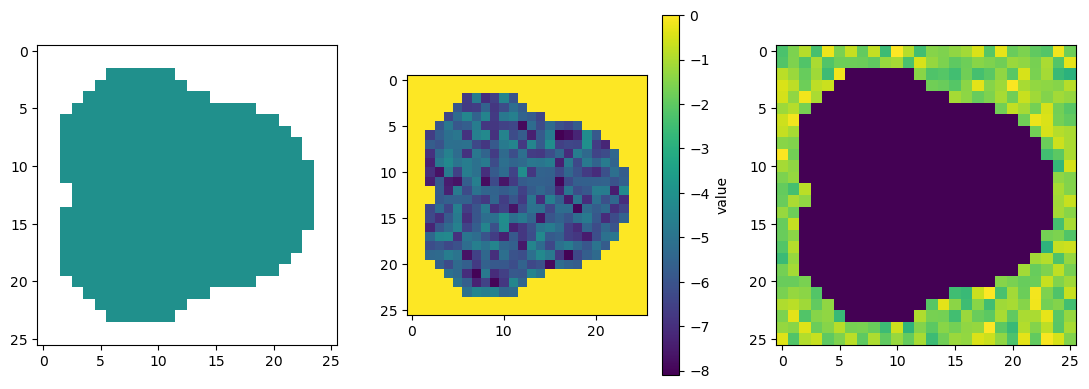

In: 0.5, out: 0.5


In [11]:
SBM_threshold = 1e-2
c_init = 0.5

grid.add_field("c", c_init)
# grid.add_field("c", c_init*(1-grid.fields["phi0"]))
mask = 1-grid.fields["phi0"] <= SBM_threshold
grid.fields["c"][mask] = np.inf

noise1 = 0.1*np.random.rand(Nx,Ny)+0.5
noise2 = 0.05*np.random.rand(Nx,Ny)
grains = ["phi1", "phi2", "phi3"]

def convert_c2mu_sbm(data, param_fit, steps=15):
    mask = 1-data.fields["phi0"] > SBM_threshold
    # start with zeros as first guess
    grid.add_field("mu")
    # REAL _mu[simgeo.components];
    # calcFunctionF_dc_SBM(_mu, phi, c, T, first_active_phase);
    # vec_addscalarNr(mu, _mu, -_mu[simgeo.components-1], simgeo.components-1);
    iter = 0
    converged = False
    while iter<steps and not converged:
        # update mu through dc/dmu*delta_mu = c - c(phi, mu_iter, T)
        # calculate the dc_dmu-matrix; NOTE: due to the symmetry, only the upper triangular part is filled and used for solving the system
        dc_dmu = 0.0
        c_iter = 0.0
        for g in grains:
            # calculate the current estimate c(mu_iter, phi)
            c_iter += sbm.ci_of_mu_log(data.fields["mu"], *param_fit["H1"], factor=factor)*data.fields[g]*(1-noise1-noise2)
            c_iter += sbm.ci_of_mu_log(data.fields["mu"], *param_fit["M"], factor=factor)*data.fields[g]*noise1
            c_iter += sbm.ci_of_mu_log(data.fields["mu"], *param_fit["H2"], factor=factor)*data.fields[g]*noise2
            dc_dmu += sbm.dci_dmu_log(data.fields["mu"], *param_fit["H1"], factor=factor)*data.fields[g]*(1-noise1-noise2)
            dc_dmu += sbm.dci_dmu_log(data.fields["mu"], *param_fit["M"], factor=factor)*data.fields[g]*noise1
            dc_dmu += sbm.dci_dmu_log(data.fields["mu"], *param_fit["H2"], factor=factor)*data.fields[g]*noise2
        c_iter /= (1-grid.fields["phi0"])
        dc_dmu /= (1-grid.fields["phi0"])
        # update mu
        delta_c = data.fields["c"][mask] - c_iter[mask]
        data.fields["mu"][mask] += delta_c / dc_dmu[mask]

        # hard coded epsilon; could be included as a key
        # converged = np.abs(delta_c) < 10e-5
        iter += 1

    if not converged:
        print(f"Not converged, {np.sum(delta_c)} lost")

factor = 1 #sbm.e_over_kbT
convert_c2mu_sbm(grid, param_fit, steps=15)
# grid.fields["mu"] *= factor
Mphase = map_to_rgb(grid.fields["phi1"]*noise1, grid.fields["phi2"]*noise1, grid.fields["phi3"]*noise1)

fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))
ax0.imshow(grid.fields["c"], cmap='viridis', vmin=0, vmax=1)
cax = ax1.imshow(grid.fields["mu"], cmap='viridis')

c_iter = 0.0
for g in grains:
    # calculate the current estimate c(mu_iter, phi)
    c_iter += sbm.ci_of_mu_log(grid.fields["mu"], *param_fit["H1"], factor=factor)*grid.fields[g]*(1-noise1-noise2)
    c_iter += sbm.ci_of_mu_log(grid.fields["mu"], *param_fit["M"], factor=factor)*grid.fields[g]*noise1
    c_iter += sbm.ci_of_mu_log(grid.fields["mu"], *param_fit["H2"], factor=factor)*grid.fields[g]*noise2
c_iter /= (1-grid.fields["phi0"])
ax2.imshow(c_iter, cmap='viridis')
# ax2.contour(grid.fields["c"], levels=[0.5], colors=['red'])
fig.colorbar(cax, ax=ax1, label='value')
plt.tight_layout()
plt.show()
print(f"In: {grid.fields['c'][10,10]}, out: {c_iter[10,10]}")